<h1>Game of Thrones characters: are they still alive?</h1>
<p>Using a dataset about the series we will try to classify whether a character is alive or not. For this, we have some data about the characters age, name, relationships and appearances in the books. Feature engineering will be required to improve the datasets compatibility with the algorithms used, and thus improve the performance of the model. The models utilized in this exercise are; logarithmic regression, K-nearest neighbors classifier, decision trees, random forests, and gradient boosted models. </p>

<h2>Setting up the kernel</h2>
<p>Importing libraries for the classifiers, scores, and other essentials for modeling. I have also increased the print displays to be able to view everything even if it has many rows.</p>
<p>Also, there are two functions that were created. The first one is to easily store and use the confusion matrix values for each model, and the second will help us determine the optimal number of neighbors for the knn model.</p>

In [1]:
#importing libraries

import pandas as pd #df essentials
import numpy as np #numpy for faster process
import matplotlib.pyplot as plt #plotting essentials
import seaborn as sns #better visualizations

from sklearn.model_selection import train_test_split # train-test split
from sklearn.linear_model import LogisticRegression  # logistic regression
import statsmodels.formula.api as smf                # logistic regression
from sklearn.metrics import confusion_matrix         # confusion matrix
from sklearn.metrics import roc_auc_score            # auc score
from sklearn.neighbors import KNeighborsClassifier   # KNN for classification
from sklearn.preprocessing import StandardScaler     # standard scaler
from sklearn.tree import DecisionTreeClassifier      # classification trees
from sklearn.tree import plot_tree  #output decision tree
from sklearn.ensemble import RandomForestClassifier #random forest classifier
from sklearn.ensemble import GradientBoostingClassifier #gradient boost classifier
from sklearn.model_selection import RandomizedSearchCV #hyper param tuning

#increasing print desplays
pd.set_option('display.max_rows', 500) 
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


In [2]:
#function to store confusion matrix values
def cm(true_y, pred_y):
    """Storing the number of true negatives, false positives, false negatives and true positives of a confusion matrix
Parameters
----------
true_y : the testing response data
pred_y : the predicted values
"""
    # unpacking the confusion matrix
    tn, \
    fp, \
    fn, \
    tp = confusion_matrix(y_true = true_y, y_pred = pred_y).ravel()
    return tn, fp, fn, tp #this is the order the will be printed in the table


In [3]:
#function for accuracy, precision, recall and specificity
def scores_table(true_y, pred_y):
    """"""
    tn, fp, fn, tp = cm(true_y, pred_y)

    accuracy = ((tn+tp)/(tn +fp + fn + tp)).round(decimals = 4)
    precision = ((tp)/(fp + tp)).round(decimals = 4)
    recall = ((tp)/(tp + fn)).round(decimals = 4)
    specificity = ((tn)/(tn + fp)).round(decimals = 4)

    #storing the strings and other variables to be printed
    table = [ ["Accuracy",accuracy],["Precision",precision], ["Recall",recall],  ["Specificity",specificity]]

    # printing the results in a table
    print(tabulate(table, headers = ['', 'Score'], tablefmt="fancy_grid"))

In [4]:
#function to find ideal number of neighbors for knn
def optimal_neighbors(x_data,
                      y_data,
                      standardize = True,
                      pct_test=0.10,
                      seed=219,
                      response_type='reg',
                      max_neighbors=20,
                      show_viz=True):
    """
Exhaustively compute training and testing results for KNN across
[1, max_neighbors]. Outputs the maximum test score and (by default) a
visualization of the results.
PARAMETERS
----------
x_data        : explanatory variable data
y_data        : response variable
standardize   : whether or not to standardize the x data, default True
pct_test      : test size for training and validation from (0,1), default 0.25
seed          : random seed to be used in algorithm, default 219
response_type : type of neighbors algorithm to use, default 'reg'
    Use 'reg' for regression (KNeighborsRegressor)
    Use 'class' for classification (KNeighborsClassifier)
max_neighbors : maximum number of neighbors in exhaustive search, default 20
show_viz      : display or surpress k-neigbors visualization, default True
"""    
    
    
    if standardize == True:
        # optionally standardizing x_data
        scaler             = StandardScaler()
        scaler.fit(x_data)
        x_scaled           = scaler.transform(x_data)
        x_scaled_df        = pd.DataFrame(x_scaled)
        x_data             = x_scaled_df



    # train-test split
    x_train, x_test, y_train, y_test = train_test_split(x_data,
                                                        y_data,
                                                        test_size = pct_test,
                                                        random_state = seed)


    # creating lists for training set accuracy and test set accuracy
    training_accuracy = []
    test_accuracy = []
    
    
    # setting neighbor range
    neighbors_settings = range(1, max_neighbors + 1)


    for n_neighbors in neighbors_settings:
        # building the model based on response variable type
        if response_type == 'reg':
            clf = KNeighborsRegressor(n_neighbors = n_neighbors)
            clf.fit(x_train, y_train)
            
        elif response_type == 'class':
            clf = KNeighborsClassifier(n_neighbors = n_neighbors)
            clf.fit(x_train, y_train)            
            
        else:
            print("Error: response_type must be 'reg' or 'class'")
        
        
        # recording the training set accuracy
        training_accuracy.append(clf.score(x_train, y_train))
    
        # recording the generalization accuracy
        test_accuracy.append(clf.score(x_test, y_test))


    # optionally displaying visualization
    if show_viz == True:
        # plotting the visualization
        fig, ax = plt.subplots(figsize=(12,8))
        plt.plot(neighbors_settings, training_accuracy, label = "training accuracy")
        plt.plot(neighbors_settings, test_accuracy, label = "test accuracy")
        plt.ylabel("Accuracy")
        plt.xlabel("n_neighbors")
        plt.legend()
        plt.show()
    
    
    # returning optimal number of neighbors
    print(f"The optimal number of neighbors is: {test_accuracy.index(max(test_accuracy))+1}")
    return test_accuracy.index(max(test_accuracy))+1

In [5]:
#function to plot a confusion matrix
def visual_cm(true_y, pred_y, labels = None):
    """
Creates a visualization of a confusion matrix.

PARAMETERS
----------
true_y : true values for the response variable
pred_y : predicted values for the response variable
labels : , default None
    """
    # visualizing the confusion matrix

    # setting labels
    lbls = labels
    

    # declaring a confusion matrix object
    cm2 = confusion_matrix(y_true = true_y, y_pred = pred_y)


    # heatmap
    sns.heatmap(cm2,
                annot       = True,
                cmap        = 'Blues',
                fmt         = 'g')


    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix of the Classifier')
    plt.show()

<h2>Exploring the original dataset</h2>
<p>After reading the data, it became evident that there were a lot of missing values. This is because many of the characters are likely mentioned at some point in the story, but their back story is not provided. Some features have only an astounding 1% of usable data, and will likely not be useful for the model unless there is a relationship between being a main character and dying. Missing values have been flagged to check for this in the future, and to know which missing values have been imputed.</p>
<p>Looking at the response variable there is some class imbalance, as 75% of the characters are alive. This will be handled in the train test split by stratifying the response variable so both sets have a similar percentage of each category.</p>
<p>The column for age is interesting, as there are some very strange outliers. Adding this to the date of birth of each character resulted in a very interesting feature, where all of the characters where still alive had the same value. This could be like the last year the character was alive (alive characters all share the same year and would continue growing outside the scope of the story).</p>

In [6]:
#Reading the data. S.No is just an identifier and should not be used
dtypes = {"S.No": str}
file = "GOT_character_predictions.xlsx"
data = pd.read_excel(io = file, dtype = dtypes) 
data.head()

,S.No,name,title,culture,dateOfBirth,mother,father,heir,house,spouse,book1_A_Game_Of_Thrones,book2_A_Clash_Of_Kings,book3_A_Storm_Of_Swords,book4_A_Feast_For_Crows,book5_A_Dance_with_Dragons,isAliveMother,isAliveFather,isAliveHeir,isAliveSpouse,isMarried,isNoble,age,numDeadRelations,popularity,isAlive
0,1,Viserys II Targaryen,NaN,NaN,NaN,Rhaenyra Targaryen,Daemon Targaryen,Aegon IV Targaryen,NaN,NaN,0,0,0,0,0,1.0,0.0,0.0,NaN,0,0,NaN,11,0.605351,0
1,2,Walder Frey,Lord of the Crossing,Rivermen,208.0,NaN,NaN,NaN,House Frey,Perra Royce,1,1,1,1,1,NaN,NaN,NaN,1.0,1,1,97.0,1,0.896321,1
2,3,Addison Hill,Ser,NaN,NaN,NaN,NaN,NaN,House Swyft,NaN,0,0,0,1,0,NaN,NaN,NaN,NaN,0,1,NaN,0,0.267559,1
3,4,Aemma Arryn,Queen,NaN,82.0,NaN,NaN,NaN,House Arryn,Viserys I Targaryen,0,0,0,0,0,NaN,NaN,NaN,0.0,1,1,23.0,0,0.183946,0
4,5,Sylva Santagar,Greenstone,Dornish,276.0,NaN,NaN,NaN,House Santagar,Eldon Estermont,0,0,0,1,0,NaN,NaN,NaN,1.0,1,1,29.0,0,0.043478,1


In [7]:
print(f"""
Size of Original Dataset
------------------------
Observations: {data.shape[0]} 
Features:     {data.shape[1]}
""") #printing the shape of the dataset


Size of Original Dataset
------------------------
Observations: 1946 
Features:     25



In [10]:
data["isAlive"].value_counts(normalize = True).round(decimals = 2) #Class imbalance
#this is managed by stratifying in the train test split

1    0.75
0    0.25
Name: isAlive, dtype: float64

In [20]:
got.describe()

,dateOfBirth,book1_A_Game_Of_Thrones,book2_A_Clash_Of_Kings,book3_A_Storm_Of_Swords,book4_A_Feast_For_Crows,book5_A_Dance_with_Dragons,isAliveMother,isAliveFather,isAliveHeir,isAliveSpouse,isMarried,isNoble,age,numDeadRelations,popularity,isAlive,m_title,m_culture,m_dateOfBirth,m_mother,m_father,m_heir,m_house,m_spouse,m_isAliveMother,m_isAliveFather,m_isAliveHeir,m_isAliveSpouse,m_age
count,433.000000,1946.000000,1946.000000,1946.000000,1946.000000,1946.000000,21.000000,26.000000,23.000000,276.000000,1946.000000,1946.000000,433.000000,1946.000000,1946.000000,1946.000000,1946.000000,1946.000000,1946.000000,1946.000000,1946.000000,1946.000000,1946.000000,1946.000000,1946.000000,1946.000000,1946.000000,1946.000000,1946.000000
mean,1577.364896,0.198356,0.374615,0.480473,0.591984,0.395170,0.714286,0.192308,0.652174,0.778986,0.141829,0.460946,-1293.563510,0.305755,0.089584,0.745632,0.517986,0.652107,0.777492,0.989209,0.986639,0.988181,0.219424,0.858171,0.989209,0.986639,0.988181,0.858171,0.777492
std,19565.414460,0.398864,0.484148,0.499747,0.491593,0.489013,0.462910,0.401918,0.486985,0.415684,0.348965,0.498601,19564.340993,1.383910,0.160568,0.435617,0.499805,0.476424,0.416037,0.103346,0.114843,0.108099,0.413963,0.348965,0.103346,0.114843,0.108099,0.348965,0.416037
min,-28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-298001.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,240.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,18.000000,0.000000,0.013378,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
50%,268.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,27.000000,0.000000,0.033445,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
75%,285.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,50.000000,0.000000,0.086957,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,298299.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,100.000000,15.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [9]:
data.info()
#information on column types and non null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1946 entries, 0 to 1945
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   S.No                        1946 non-null   object 
 1   name                        1946 non-null   object 
 2   title                       938 non-null    object 
 3   culture                     677 non-null    object 
 4   dateOfBirth                 433 non-null    float64
 5   mother                      21 non-null     object 
 6   father                      26 non-null     object 
 7   heir                        23 non-null     object 
 8   house                       1519 non-null   object 
 9   spouse                      276 non-null    object 
 10  book1_A_Game_Of_Thrones     1946 non-null   int64  
 11  book2_A_Clash_Of_Kings      1946 non-null   int64  
 12  book3_A_Storm_Of_Swords     1946 non-null   int64  
 13  book4_A_Feast_For_Crows     1946 

In [15]:
data.isnull().sum()
#number of nulls per column

S.No                             0
name                             0
title                         1008
culture                       1269
dateOfBirth                   1513
mother                        1925
father                        1920
heir                          1923
house                          427
spouse                        1670
book1_A_Game_Of_Thrones          0
book2_A_Clash_Of_Kings           0
book3_A_Storm_Of_Swords          0
book4_A_Feast_For_Crows          0
book5_A_Dance_with_Dragons       0
isAliveMother                 1925
isAliveFather                 1920
isAliveHeir                   1923
isAliveSpouse                 1670
isMarried                        0
isNoble                          0
age                           1513
numDeadRelations                 0
popularity                       0
isAlive                          0
dtype: int64

In [8]:
# looping to detect features with missing values
for col in data:

    # creating columns with 1s if missing and 0 if not
    if data[col].isnull().astype(int).sum() > 0:
        data['m_'+col] = data[col].isnull().astype(int)

<h2>Handling missing values</h2>
<p>Since there is a large amount of missing values, imputation may change the results quite a bit. It is important to analyze the data before imputing any value. For example, in the case of the missing values in the column isAliveSpouse zeros have been imputed as all the missing values are from people that are not married. In this case, no other value would make sense, and I did not want to add an "unknown" value. However, this may cause a change in the relationship as perhaps those that are widowed die less/more than those who are single. Since there is a column for isMarried as well, this should not be such a big problem.</p>
<p>The name feature is not useful, so a relationship between the characters gender and them dying was investigated, but it did not prove to be too useful. For other columns, observations were grouped to make each sample have a larger size, as small sample sizes are not useful for the models. For example, the characters house and culture in the series.</p>

In [14]:
data[["isAliveSpouse","isMarried"]].groupby(by = "isAliveSpouse", dropna=False).sum()
#The Nans in isAliveSpouse means the are not married. I will impute 0s

,isMarried
isAliveSpouse,
0.0,61
1.0,215
NaN,0


In [18]:
got = data.copy()
first_df = got[got[["age","dateOfBirth"]].notnull().all(axis=1)]
second_df= got[got[["age","dateOfBirth"]].isnull().all(axis=1)]
second_df.shape
#same missing values for both columns

#This is true for age - dateOfBirth, mother - isAliveMother, father - isAliveFather, heir - isAliveHeir, spouse - isAliveSpouse

#https://stackoverflow.com/questions/61300887/pandas-selecting-rows-with-missing-values-in-multiple-columns


(1513, 38)

In [ ]:
import gender_guesser.detector as gender

# looping to guess gender
for name in got['First_name'].unique():
    guess = gender.Detector().get_gender(name)
    placeholder_lst.append(guess)



In [9]:
#hard coding the output from the code above because it takes too long to process
#I hid this because it takes up a lot of my screen since I have wrapping cells in the kernel 

placeholder_lst = ['unknown', 'unknown', 'andy', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'male', 'male', 'mostly_male', 'mostly_male', 'mostly_male', 'mostly_male', 'mostly_male', 'mostly_male', 'unknown', 'male', 'unknown', 'unknown', 'male', 'male', 'female', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'mostly_female', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'male', 'male', 'andy', 'andy', 'unknown', 'andy', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'male', 'male', 'unknown', 'male', 'male', 'male', 'male', 'male', 'male', 'male', 'mostly_male', 'male', 'mostly_male', 'mostly_male', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'male', 'unknown', 'male', 'unknown', 'male', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'mostly_male', 'unknown', 'unknown', 'male', 'female', 'andy', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'mostly_male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'mostly_female', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'andy', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'male', 'male', 'unknown', 'unknown', 'unknown', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'male', 'female', 'female', 'female', 'female', 'female', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'mostly_female', 'female', 'unknown', 'mostly_female', 'unknown', 'female', 'unknown', 'female', 'unknown', 'male', 'male', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'male', 'unknown', 'andy', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'male', 'male', 'male', 'male', 'male', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'female', 'female', 'female', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male', 'male', 'male', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'mostly_female', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male', 'male', 'male', 'unknown', 'male', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'mostly_male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'mostly_male', 'female', 'male', 'male', 'male', 'female', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'male', 'male', 'male', 'female', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'andy', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'female', 'male', 'unknown', 'unknown', 'female', 'male', 'unknown', 'male', 'unknown', 'unknown', 'male', 'female', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'female', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'male', 'male', 'male', 'unknown', 'male', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'male', 'male', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'male', 'unknown', 'male', 'male', 'unknown', 'unknown', 'male', 'male', 'unknown', 'male', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'male', 'female', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'female', 'female', 'female', 'unknown', 'unknown', 'male', 'male', 'male', 'male', 'male', 'male', 'male', 'male', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'mostly_male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'mostly_female', 'mostly_female', 'mostly_female', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'female', 'male', 'male', 'male', 'male', 'unknown', 'female', 'female', 'female', 'unknown', 'mostly_male', 'unknown', 'unknown', 'male', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male', 'male', 'female', 'male', 'female', 'unknown', 'unknown', 'female', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male', 'male', 'unknown', 'unknown', 'female', 'unknown', 'female', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'male', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'female', 'unknown', 'male', 'unknown', 'unknown', 'mostly_female', 'male', 'female', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'female', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'male', 'unknown', 'male', 'male', 'female', 'mostly_female', 'female', 'mostly_female', 'mostly_female', 'mostly_female', 'mostly_female', 'mostly_female', 'mostly_female', 'unknown', 'unknown', 'female', 'female', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'female', 'unknown', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'female', 'unknown', 'female', 'unknown', 'unknown', 'female', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male', 'male', 'unknown', 'unknown', 'male', 
                   'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'female', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'female', 'unknown', 'unknown', 'male', 'male', 'male', 'male', 'male', 'unknown', 'unknown', 'unknown', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'female', 'mostly_male', 'unknown', 'female', 'male', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'male', 'male', 'male', 'male', 'male', 'unknown', 'unknown', 'male', 'male', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'male', 'male', 'unknown', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'male', 'male', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male', 'male', 'male', 'male', 'male', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'female', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male', 'female', 'unknown', 'female', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'male', 'unknown', 'unknown', 'male', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'mostly_male', 'male', 'unknown', 'unknown', 'male', 'male', 'male', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'female', 'female', 'female', 'male', 'male', 'unknown', 'unknown', 'unknown', 'male', 'male', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male', 'unknown', 'male', 'unknown', 'female', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male', 'male', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'male', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'male', 'unknown', 'male', 'male', 'andy', 'male', 'male', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'female', 'unknown', 'male', 'male', 'male', 'male', 'male', 'male', 'mostly_male', 'mostly_male', 'mostly_male', 'mostly_male', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'male', 'male', 'unknown', 'male', 'male', 'unknown', 'male', 'male', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'female', 'female', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'male', 'male', 'unknown', 'unknown', 'male', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'male', 'male', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'male', 'male', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male', 'unknown', 'unknown', 'female', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'mostly_male', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'male', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'mostly_female', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'male', 'male', 'unknown', 'unknown', 'unknown', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'mostly_female', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'male', 'male', 'mostly_female', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'female', 'unknown', 'female', 'unknown', 'female', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'andy', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'female', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'mostly_female', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male', 'male', 'male', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'male', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male', 'unknown', 'male', 'male', 'unknown', 'male', 'unknown', 'male', 'male', 'male', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'male', 'male', 'male', 'male', 'male', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'mostly_male', 'male', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'male', 'male', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'mostly_female', 'unknown', 'unknown', 'unknown', 'female', 'male', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 
    'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'female', 'male', 'mostly_male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown']

In [10]:
got = data.copy()

# converting list into a series
got['gender_guess'] = pd.Series(placeholder_lst)


# checking results
got['gender_guess'].value_counts()
got['gender'] = np.where(got['gender_guess'] == 'unknown', 'unknown',  np.where(got['gender_guess'] == 'male', 'male', np.where( got['gender_guess'] == 'mostly_male', 'male', np.where(got['gender_guess'] == "andy", 'unknown','female'))))


#imputing zeroes for isAliveSpouse or no_col for str values
got["isAliveSpouse"].fillna(value = 0, inplace = True)
got["isAliveHeir"].fillna(value = 0, inplace = True)
got["heir"].fillna(value = 'No_heir', inplace = True)
got["title"].fillna(value = 'No_title', inplace = True)

#imputing unknowns
got["mother"].fillna(value = 'unknown_mother', inplace = True)
got["father"].fillna(value = 'unknown_father', inplace = True)
got["spouse"].fillna(value = 'unknown_spouse', inplace = True)

got["isAliveMother"].fillna(value = 'unknown_mother_alive', inplace = True)
got["isAliveFather"].fillna(value = 'unknown_father_alive', inplace = True)
got['has_title'] = np.where(got['title'] == 'None', 'None', 'Title' )

names = got['name'].str.split(n = 2, expand = True)
got['First_name'] = names[0]
# used for the gender guesser 


# looping to find the 8 most important houses according to https://www.sideshow.com/geek/ranking-the-9-major-game-of-thrones-houses/ 
for row, datum in got.iterrows():
   
    if ' Stark' in got.loc[ row , 'name']:
        got.loc[row, 'house_imputation'] = 'House Stark'
    elif ' Targaryen' in got.loc[ row , 'name']:
        got.loc[row, 'house_imputation'] = 'House Targaryen'
    elif ' Lannister' in got.loc[ row , 'name']:
        got.loc[row, 'house_imputation'] = 'House Lannister'
    elif ' Greyjoy' in got.loc[ row , 'name']:
        got.loc[row, 'house_imputation'] = 'House Greyjoy'
    elif ' Tyrell' in got.loc[ row , 'name']:
        got.loc[row, 'house_imputation'] = 'House Tyrell'
    elif ' Baratheon' in got.loc[ row , 'name']:
        got.loc[row, 'house_imputation'] = 'House Baratheon'
    elif ' Martell' in got.loc[ row , 'name']:
        got.loc[row, 'house_imputation'] = 'House Martell'
    elif ' Arryn' in got.loc[ row , 'name']:
        got.loc[row, 'house_imputation'] = 'House Arryn'
    elif ' Tully' in got.loc[ row , 'name']:
        got.loc[row, 'house_imputation'] = 'House Tully'
    else:
        got.loc[row, 'house_imputation'] = 'Unknown'

houses = ['House Stark', 'House Targaryen', 'House Lannister']#, 'House Greyjoy', 'House Tyrell', 'House Baratheon', 'House Martell', 'House Arryn', 'House Tully'] better correlation with only the biggest 3


got['house'].fillna(value = got['house_imputation'], inplace = True)

#house grouping by 3 most important, others and unknown
got['house_groups'] = np.where(got['house'].isin(houses), "Powerful", np.where(got['house'] == "Unknown" , "Unknown", "Other"))
got['house'] = got['house'].str.lower()
got['culture'] = got['culture'].str.lower()

#creating dummies
one_hot_houses = pd.get_dummies(got['house_groups'])
got = got.join([one_hot_houses])
one_hot_titles = pd.get_dummies(got['has_title'])
got = got.join([one_hot_titles])

#summing age and date of birth, live people get 305, so its probably the current year (like 2021 for us)
got['age'].fillna(value = got['age'].median(), inplace = True)
got['dateOfBirth'].fillna(value = got['dateOfBirth'].median(), inplace = True)
got['Last_seen'] = got['dateOfBirth'] + got['age']

# impute culture based on family name
# the culture was based on the mode of each house
for index, val in got.iterrows():

    if ' Stark' in got.loc[ index , 'name']:
        got.loc[index, 'culture_imputation'] = 'Northmen'
    elif ' Targaryen' in got.loc[ index , 'name']:
        got.loc[index, 'culture_imputation'] = 'Valyrian'
    elif ' Lannister' in got.loc[ index , 'name']:
        got.loc[index, 'culture_imputation'] = 'Westerman_Westerlands'
    elif ' Greyjoy' in got.loc[ index , 'name']:
        got.loc[index, 'culture_imputation'] = 'Ironborn_Ironmen'
    elif ' Tyrell' in got.loc[ index , 'name']:
        got.loc[index, 'culture_imputation'] = 'Reach'
    elif ' Baratheon' in got.loc[ index , 'name']:
        got.loc[index, 'culture_imputation'] = 'Stormlands'
    elif ' Martell' in got.loc[ index , 'name']:
        got.loc[index, 'culture_imputation'] = 'Dornish'
    elif ' Arryn' in got.loc[ index , 'name']:
        got.loc[index, 'culture_imputation'] = 'Valemen'
    elif ' Tully' in got.loc[ index , 'name']:
        got.loc[index, 'culture_imputation'] = 'Rivermen'
    else:
        got.loc[index, 'culture_imputation'] = 'Unknown'
got['culture'].fillna(value = got['culture_imputation'], inplace = True)

#grouping cultures and titles bc of typos or diff names for same ones
got['culture2'] = got['culture'].str.lower().str.extract(r'(.{0,4})')
got['title2'] = got['title'].str.lower().str.extract(r'(.{0,4})')

got['book_appearance_rate'] = (got['book1_A_Game_Of_Thrones'] + got['book2_A_Clash_Of_Kings'] + got['book3_A_Storm_Of_Swords'] + got['book4_A_Feast_For_Crows'] + got['book5_A_Dance_with_Dragons'])#/5

#mean dead relations by house may be better than just the numbers
got['DeadRelations_house'] = np.nan
got['DeadRelations_house'].fillna(value = got.groupby(by = 'house')['numDeadRelations'].transform('mean'), inplace = True)



In [33]:
#this helps me visualize the distribution between each variable and the response variable
for col in got: 
    if got[col].dtype == int or got[col].dtype == object: 
        print(pd.crosstab(got[col],got.isAlive))

isAlive  0  1
S.No         
1        1  0
10       0  1
100      0  1
1000     0  1
1001     1  0
...     .. ..
995      0  1
996      0  1
997      1  0
998      0  1
999      0  1

[1946 rows x 2 columns]
isAlive           0  1
name                  
Abelar Hightower  0  1
Addam             0  1
Addam Frey        0  1
Addam Marbrand    0  1
Addam Osgrey      1  0
...              .. ..
Zekko             0  1
Zharaq zo Loraq   0  1
Zhoe Blanetree    0  1
Zia Frey          0  1
Zollo             0  1

[1946 rows x 2 columns]
isAlive                                               0    1
title                                                       
Acorn Hall                                            0    2
Andals                                                1    1
Arbor                                                 0    1
Archmaester                                           0   21
Ashford                                               0    2
Banefort                                  

isAlive                                   0    1
house                                           
alchemists' guild                         1    6
antler men                                0    1
band of nine                              1    0
black ears                                0    2
blacks                                    4    0
brave companions                          8    4
brotherhood without banners               1   18
burned men                                0    2
chataya's brothel                         0    5
citadel                                   0    1
city watch of king's landing              1    0
company of the cat                        0    1
drowned men                               0    5
faceless men                              0    2
faith of the seven                        2   15
golden company                            0    2
good masters                              2    0
graces                                    0    1
happy port          

isAlive            0     1
m_isAliveMother           
0                 18     3
1                477  1448
isAlive            0     1
m_isAliveFather           
0                 20     6
1                475  1445
isAlive          0     1
m_isAliveHeir           
0               18     5
1              477  1446
isAlive            0     1
m_isAliveSpouse           
0                 85   191
1                410  1260
isAlive    0     1
m_age             
0        163   270
1        332  1181
isAlive          0     1
gender_guess            
andy             2     8
female          21   104
male            99   282
mostly_female    5    16
mostly_male      5    19
unknown        363  1022
isAlive    0     1
gender            
female    26   120
male     104   301
unknown  365  1030
isAlive      0    1
has_title          
None       239  769
Title      256  682
isAlive      0  1
First_name       
Abelar       0  1
Addam        2  3
Addison      0  1
Aegon       10  2
Aegor        1  0

In [38]:
#no more missing values
got.isnull().sum()

S.No                          0
name                          0
title                         0
culture                       0
dateOfBirth                   0
mother                        0
father                        0
heir                          0
house                         0
spouse                        0
book1_A_Game_Of_Thrones       0
book2_A_Clash_Of_Kings        0
book3_A_Storm_Of_Swords       0
book4_A_Feast_For_Crows       0
book5_A_Dance_with_Dragons    0
isAliveMother                 0
isAliveFather                 0
isAliveHeir                   0
isAliveSpouse                 0
isMarried                     0
isNoble                       0
age                           0
numDeadRelations              0
popularity                    0
isAlive                       0
m_title                       0
m_culture                     0
m_dateOfBirth                 0
m_mother                      0
m_father                      0
m_heir                        0
m_house 

<h2>Features for Modeling</h2>
<p>Apart from using the feature importance output of the decision tree algorith, the features with the highest correlations (absolute value) were tried to find the best model. Since it is a categorization problem with a lot of binary features, the correlations aren't a perfect tell for which values will work best, but they give a general guide as to which are actually related to the response variable</p>

In [18]:
#Finding the most correlated features
got.corr().abs()['isAlive'].sort_values(ascending = False).round(decimals = 3)[1:10]

Last_seen                  0.306
book4_A_Feast_For_Crows    0.269
DeadRelations_house        0.236
numDeadRelations           0.192
popularity                 0.183
Powerful                   0.173
m_age                      0.150
m_dateOfBirth              0.150
book1_A_Game_Of_Thrones    0.147
Name: isAlive, dtype: float64

<h3>Best Features</h3>
<p>The best features found are the list candidate_3. These had the highes auc score for at least one of the models. Other acceptable trials were recorded. Trials that resulted in very low values were not included as they provide no useful information for the models.</p>

In [11]:
#Some candidates for models

candidate_dict = { # full model
 'full_model': ['isAliveHeir', 'isAliveSpouse', 'isMarried', 'isNoble', 'popularity', 'm_mother', 'm_father', 'Powerful', 'Unknown', 'Title', 'Last_seen', 'book_appearance_rate', 'DeadRelations_house','book4_A_Feast_For_Crows', 'book1_A_Game_Of_Thrones'],   
    #correlated features
    'candidate_1': ['Last_seen','popularity', 'Powerful', 'numDeadRelations'],
    'candidate_2': ['Last_seen','popularity', 'Powerful', 'numDeadRelations', 'isMarried', 'isNoble'],
    
    
    #best features
    'candidate_3': ['Last_seen', 'popularity', 'DeadRelations_house', 'book4_A_Feast_For_Crows', 'book1_A_Game_Of_Thrones'],
    
    
    #correlated features added
    'candidate_4': ['Last_seen', 'popularity', 'DeadRelations_house', 'book4_A_Feast_For_Crows', 'Powerful'],
    'candidate_5': ['Last_seen', 'popularity', 'numDeadRelations', 'book4_A_Feast_For_Crows', 'book1_A_Game_Of_Thrones'],
    #important features from DT
    'candidate_6': ['Last_seen', 'popularity', 'numDeadRelations', 'book4_A_Feast_For_Crows', 'book1_A_Game_Of_Thrones', 'isNoble', 'isMarried', 'Unknown'],
    'candidate_7': ['Last_seen', 'popularity', 'numDeadRelations', 'book4_A_Feast_For_Crows', 'isNoble', 'isMarried', 'book_appearance_rate'],
    'candidate_8' : ['Last_seen','popularity', 'Powerful', 'numDeadRelations', 'isMarried', 'isNoble']
}

<h2>Modeling</h2>
<p>The models used are logarithmic regression, K-nearest neighbors classifier, decision trees, random forests, and gradient boosted models. The data was scaled to see the effect of standardization on the classifiers, especially the KNN algorithm as standardizing help it calculate distances wiith similar values, rather than ignoring the column last_seen, for example, due to it having a larger range than other features. However, the gradient boosted model without scaling performed better than the scaled KNN algorithm, so this step was not used in the end.</p>
<p>The data was split into test and train, and the response variable was stratified, as seen below so each set had a similar distribution of values. This prevents a random train set of values with class imbalance that is not reflected in the test set and then causes the model to perform poorly on the new data.</p>

In [12]:
#scaling the data, especially so KNN can calculate distances well rather than in different ranges
scaler = StandardScaler()

#scaling the data (will affect all columns)
columns = candidate_dict['candidate_3']
scaler.fit(got.loc[:,columns])
columns_scaled = scaler.transform(got.loc[:,columns])
scaled_columns = pd.DataFrame(columns_scaled)

In [13]:
#Train test splitting with desired parameters

#normal columns
features = got.loc[:,columns]

#scaled columns - i just comment out this one if I want to run it without scaling.
#features = scaled_columns

y = got.loc[:,'isAlive']


# train-test split with stratification
x_train, x_test, y_train, y_test = train_test_split(features, y, test_size = 0.10,  random_state = 219, stratify = y) # preserving balance


# merging training data for statsmodels
train = pd.concat([x_train, y_train], axis = 1)



In [14]:
#checking if it was correctly stratified

print(f"""

Response Variable Proportions (Training Set)
--------------------------------------------
{y_train.value_counts(normalize = True).round(decimals = 2)}



Response Variable Proportions (Testing Set)
--------------------------------------------
{y_test.value_counts(normalize = True).round(decimals = 2)}
""")



Response Variable Proportions (Training Set)
--------------------------------------------
1    0.75
0    0.25
Name: isAlive, dtype: float64



Response Variable Proportions (Testing Set)
--------------------------------------------
1    0.74
0    0.26
Name: isAlive, dtype: float64



<p>These are some of the parameters changed by hand before trying to hypertune the model, used to check what ranges could be acceptable to get better scores</p>

In [15]:
#setting some parameters
max_depth = 8
min_samples_leaf = 25
random_state = 219
class_weight = 'balanced'

<h3>Logistic Regression</h3>
<p>Running the logistic regression model on the data and storing the results</p>

In [16]:
#logistic regression
# INSTANTIATING a logistic regression model
logreg = LogisticRegression(solver = 'lbfgs',
                            C = 1,
                            random_state = 219)


# FITTING the training data
logreg_fit = logreg.fit(x_train, y_train)


# PREDICTING based on the testing set
logreg_pred = logreg_fit.predict(x_test)

# saving scoring data for future use
logreg_train_score = logreg_fit.score(x_train, y_train).round(4) # accuracy
logreg_test_score  = logreg_fit.score(x_test, y_test).round(4) # accuracy

# saving AUC score for future use
logreg_auc_score = roc_auc_score(y_true  = y_test,
                                 y_score = logreg_pred).round(decimals = 4)

<h3>KNN</h3>
<p>Running the k-nearest neighbors classifier model on the data and storing the results. The graph below shows the ideal number of neighbors to run to get a better prediction</p>

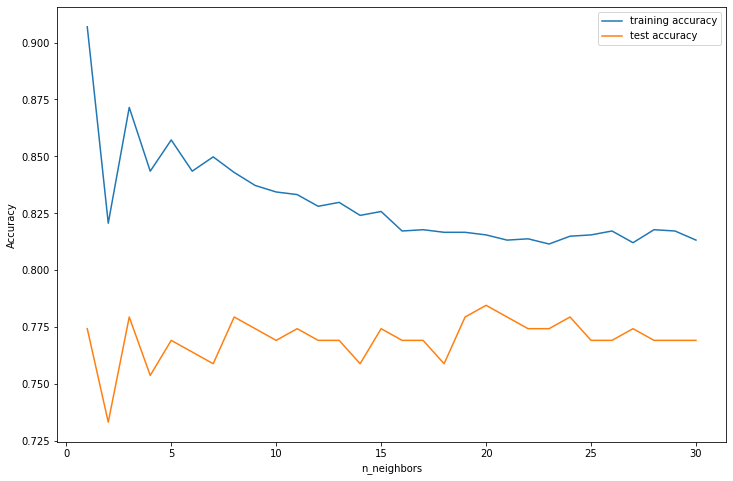

The optimal number of neighbors is: 20


20

In [17]:
#determining number of neighbors for knn
optimal_neighbors(features,
                      y,
                      standardize = True,
                      pct_test=0.10,
                      seed=219,
                      response_type='class',
                      max_neighbors=30)

In [18]:
#KNN model


# INSTANTIATING a logistic regression model
KNN = KNeighborsClassifier(n_neighbors = 20)


# FITTING the training data
KNN_fit = KNN.fit(x_train, y_train)


# PREDICTING based on the testing set
KNN_pred = KNN_fit.predict(x_test)

# saving scoring data for future use
KNN_train_score = KNN_fit.score(x_train, y_train).round(4) # accuracy
KNN_test_score  = KNN_fit.score(x_test, y_test).round(4) # accuracy

# saving AUC score for future use
KNN_auc_score = roc_auc_score(y_true  = y_test, y_score = KNN_pred).round(decimals = 4)



<h3>CART model</h3>
<p>Running the decision tree classifier model on the data and storing the results. A feature importance graph helps us visualize which explanatory variables have large predictive capabilities for this model.</p>

<Figure size 10800x3600 with 0 Axes>

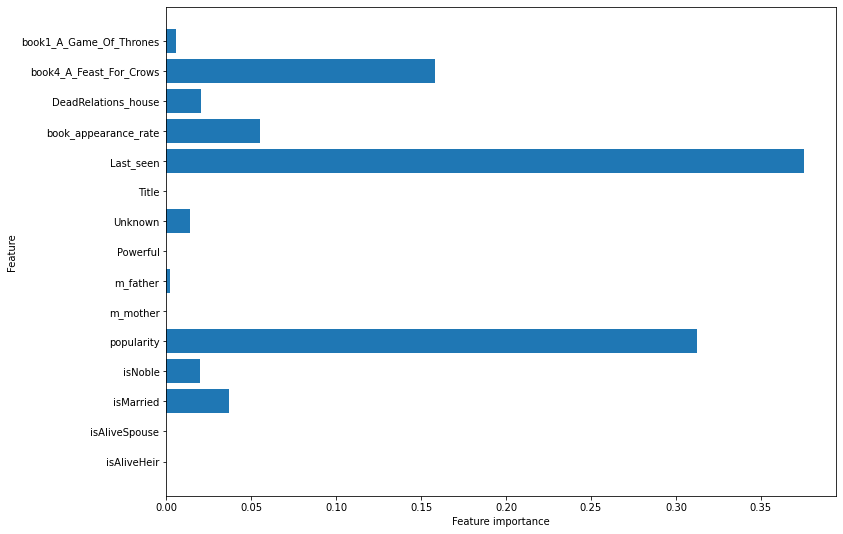

In [82]:
def plot_feature_importances(model, train, export = False):
    """
    Plots the importance of features from a CART model.
    
    PARAMETERS
    ----------
    model  : CART model
    train  : explanatory variable training data
    export : whether or not to export as a .png image, default False
    """
    
    # declaring the number
    n_features = x_train.shape[1]
    
    # setting plot window
    fig, ax = plt.subplots(figsize=(12,9))
    
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), train.columns)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    
    if export == True:
        plt.savefig('Tree_Leaf_50_Feature_Importance.png')
        
# setting figure size
plt.figure(figsize=(150,50))

full_features = got.loc[:, candidate_dict['full_model']]
# plotting feature importance
plot_feature_importances(DT_fit,
                         train = full_features,
                         export = False)


In [19]:
#Decision trees
# INSTANTIATING a logistic regression model
DT = DecisionTreeClassifier(max_depth = max_depth, min_samples_leaf = min_samples_leaf, random_state = random_state, class_weight = class_weight)


# FITTING the training data
DT_fit = DT.fit(x_train, y_train)


# PREDICTING based on the testing set
DT_pred = DT_fit.predict(x_test)

# saving scoring data for future use
DT_train_score = DT_fit.score(x_train, y_train).round(4) # accuracy
DT_test_score  = DT_fit.score(x_test, y_test).round(4) # accuracy

# saving AUC score for future use
DT_auc_score = roc_auc_score(y_true  = y_test, y_score = DT_pred).round(decimals = 4)


<h3>Random Forest</h3>
<p>Running the random forest classifier model on the data and storing the results.</p>

In [20]:
#Random Forest

# INSTANTIATING a logistic regression model
RF = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', max_depth = max_depth, min_samples_leaf = min_samples_leaf, random_state = random_state, class_weight = class_weight)


# FITTING the training data
RF_fit = RF.fit(x_train, y_train)


# PREDICTING based on the testing set
RF_pred = RF_fit.predict(x_test)

# saving scoring data for future use
RF_train_score = RF_fit.score(x_train, y_train).round(4) # accuracy
RF_test_score  = RF_fit.score(x_test, y_test).round(4) # accuracy

# saving AUC score for future use
RF_auc_score = roc_auc_score(y_true  = y_test, y_score = RF_pred).round(decimals = 4)


<h3>Gradient Boosted Model</h3>
<p>Running the gradient boosted classifier model on the data and storing the results</p>

In [21]:
#Gradient Boost

# INSTANTIATING a logistic regression model
GBM = GradientBoostingClassifier(max_depth = 8, random_state = 219)


# FITTING the training data
GBM_fit = GBM.fit(x_train, y_train)


# PREDICTING based on the testing set
GBM_pred = GBM_fit.predict(x_test)

# saving scoring data for future use
GBM_train_score = GBM_fit.score(x_train, y_train).round(4) # accuracy
GBM_test_score  = GBM_fit.score(x_test, y_test).round(4) # accuracy

# saving AUC score for future use
GBM_auc_score = roc_auc_score(y_true  = y_test, y_score = GBM_pred).round(decimals = 4)



<h3>Preliminary Results</h3>
<p>Below is a table with all the models that were run. The model with the best auc is the random forest. However, the train gap is just about 0.05. For this reason I am also interested in tuning the GB model, as it has a similar auc score, but the gap is only 0.01. The other three models have gaps over 0.05, or lower auc values, so I do not consider it a valuable use of time to tune these, when the other two work better.</p>

In [22]:
# printing the results

#importing table output library
from tabulate import tabulate

#storing the strings and other variables to be printed
table = [["Log R",logreg_train_score,logreg_test_score, logreg_auc_score, cm(y_test, logreg_pred) ],["KNN",KNN_train_score,KNN_test_score, KNN_auc_score, cm(y_test, KNN_pred)],["DT",DT_train_score, DT_test_score, DT_auc_score, cm(y_test, DT_pred)], ["RF (second best)",RF_train_score,RF_test_score, RF_auc_score, cm(y_test, RF_pred)], ["GBM (best)",GBM_train_score,GBM_test_score,GBM_auc_score, cm(y_test, GBM_pred)]]

# printing the results in a table
print(tabulate(table, headers=["Classifier", "Train score", "Test score", "AUC score", "Confusion matrix"], tablefmt="fancy_grid"))



╒══════════════════╤═══════════════╤══════════════╤═════════════╤════════════════════╕
│ Classifier       │   Train score │   Test score │   AUC score │ Confusion matrix   │
╞══════════════════╪═══════════════╪══════════════╪═════════════╪════════════════════╡
│ Log R            │        0.8075 │       0.8462 │      0.7197 │ (23, 27, 3, 142)   │
├──────────────────┼───────────────┼──────────────┼─────────────┼────────────────────┤
│ KNN              │        0.8509 │       0.9077 │      0.8462 │ (36, 14, 4, 141)   │
├──────────────────┼───────────────┼──────────────┼─────────────┼────────────────────┤
│ DT               │        0.7464 │       0.7487 │      0.7917 │ (44, 6, 43, 102)   │
├──────────────────┼───────────────┼──────────────┼─────────────┼────────────────────┤
│ RF (second best) │        0.7756 │       0.8359 │      0.8503 │ (44, 6, 26, 119)   │
├──────────────────┼───────────────┼──────────────┼─────────────┼────────────────────┤
│ GBM (best)       │        0.9178 │       

<h2>Hyperparameter Tuning</h2>
<p>Tuning the parameters on models can help the model perform better and/or avoid overfitting in some cases. The models we created do not overfit the data, but parameters will be altered to check if there is a better model than the default.</p>

<h3>Random Forest</h3>
<p>For this model, the most interesting hyper parameter was the class_weight, as changing this to balanced or balanced_subsample improved the model quite a lot. Perhaps a combination of this with a different number of estimators or any other parameter does a better job predicting the data.</p>

In [130]:
from sklearn.metrics import make_scorer   
# train/test split with the full model

# declaring a hyperparameter space
estimator_range  = np.arange(500, 2000, 250)
leaf_range       = np.arange(1, 21, 10)
criterion_range  = ['gini', 'entropy']
bootstrap_range  = [True, False]
max_depth_range = np.arange(1,8,1)
class_weight = ['balanced', "balanced_subsample"]

# creating a hyperparameter grid
param_grid = {'n_estimators'     : estimator_range,
              'min_samples_leaf' : leaf_range,
              'criterion'        : criterion_range,
              'bootstrap'        : bootstrap_range,
              'max_depth' : max_depth_range, 
             'class_weight' : class_weight}


# INSTANTIATING the model object without hyperparameters
forest_grid = RandomForestClassifier(random_state = 219)


# GridSearchCV object
forest_cv = RandomizedSearchCV(estimator           = forest_grid,
                               param_distributions = param_grid,
                               cv         = 3,
                               n_iter     = 1000,
                               scoring    = make_scorer(roc_auc_score,
                                            needs_threshold = False))


# FITTING to the FULL DATASET (due to cross-validation)
forest_cv.fit(features, y)


# PREDICT step is not needed


# printing the optimal parameters and best score
print("Tuned Parameters  :", forest_cv.best_params_)
print("Tuned Training AUC:", forest_cv.best_score_.round(4))

c:\users\kirst\pycharmprojects\machinelearning\venv\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 672 is smaller than n_iter=1000. Running 672 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Tuned Parameters  : {'n_estimators': 1500, 'min_samples_leaf': 1, 'max_depth': 6, 'criterion': 'entropy', 'class_weight': 'balanced_subsample', 'bootstrap': True}
Tuned Training AUC: 0.7747


In [132]:
# best estimators based on RandomizedSearchCV
forest_cv.best_estimator_

RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=6, n_estimators=1500, random_state=219)

In [23]:
# INSTANTIATING a logistic regression model
RF_tuned = RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=6, n_estimators=1500, random_state=219)


# FITTING to the FULL DATASET (due to cross-validation)
RF_tuned_fit = RF_tuned.fit(features, y)


# PREDICTING based on the testing set
RF_tuned_pred = RF_tuned_fit.predict(x_test)

# saving scoring data for future use
RF_tuned_train_score = RF_tuned_fit.score(x_train, y_train).round(4) # accuracy
RF_tuned_test_score  = RF_tuned_fit.score(x_test, y_test).round(4) # accuracy

# saving AUC score for future use
RF_tuned_auc_score = roc_auc_score(y_true  = y_test, y_score = RF_tuned_pred).round(decimals = 4)

<h3>Gradient Boosted Model</h3>
<p>The learning rate is perhaps one of the most important parameters for gbms. In this case, it is interesting that the learning rate resulted to be so low, despite the fact that there isn't an immense amount of data in our dataframe. In this case, the best model had an auc score over 0.9, which is not a good indication, so the second best model for this hyperparameter tuning was used.</p>

In [149]:
# declaring a hyperparameter space
learn_range        = np.arange(0.01, 1, 0.05)
estimator_range    = np.arange(1300, 2700, 100)
depth_range        = np.arange(3, 8, 1)
leaf_range       = np.arange(1, 30, 10)
subsample_range = np.arange(0.3, 1, 0.1)


# creating a hyperparameter grid
param_grid = {'learning_rate' : learn_range,
              'max_depth'     : depth_range,
              'n_estimators'  : estimator_range, 
               'min_samples_leaf' : leaf_range, 
             'subsample':subsample_range}


# INSTANTIATING the model object without hyperparameters
full_gbm_grid = GradientBoostingClassifier(random_state = 219)


# GridSearchCV object
full_gbm_cv = RandomizedSearchCV(estimator = full_gbm_grid,
                                 param_distributions = param_grid,
                                 cv                  = 3,
                                 n_iter              = 100,
                                 random_state        = 219,
                                 scoring             = make_scorer(roc_auc_score,
                                                       needs_threshold = False))


# FITTING to the FULL DATASET (due to cross-validation)
full_gbm_cv.fit(features, y)


# PREDICT step is not needed


# printing the optimal parameters and best score
print("Tuned Parameters  :", full_gbm_cv.best_params_)
print("Tuned Training AUC:", full_gbm_cv.best_score_.round(4))

Tuned Parameters  : {'subsample': 0.7000000000000002, 'n_estimators': 1400, 'min_samples_leaf': 1, 'max_depth': 4, 'learning_rate': 0.01}
Tuned Training AUC: 0.7343


In [162]:
full_gbm_cv.best_estimator_

GradientBoostingClassifier(learning_rate=0.01, max_depth=4, n_estimators=1400,
                           random_state=219, subsample=0.7000000000000002)

In [170]:
# best estimators based on RandomizedSearchCV
all_results = pd.DataFrame(full_gbm_cv.cv_results_)
all_results.sort_values('rank_test_score').head(n = 2)
#trying the second best model because the best one goes over 0.90 auc

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_subsample,param_n_estimators,param_min_samples_leaf,param_max_depth,param_learning_rate,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
12,1.203558,0.040719,0.014686,0.000497,0.7,1400,1,4,0.01,"{'subsample': 0.7000000000000002, 'n_estimator...",0.706680,0.686433,0.809656,0.734256,0.053952,1
54,1.338457,0.010964,0.025009,0.006544,0.6,1400,11,5,0.01,"{'subsample': 0.6000000000000001, 'n_estimator...",0.701584,0.683471,0.810766,0.731940,0.056227,2


In [24]:
# INSTANTIATING a logistic regression model
GBM_tuned = GradientBoostingClassifier(learning_rate=0.01, min_samples_leaf = 11, max_depth=5, n_estimators=1400, random_state=219, subsample=0.6)



# FITTING to the FULL DATASET (due to cross-validation)
GBM_tuned_fit = GBM_tuned.fit(features, y)


# PREDICTING based on the testing set
GBM_tuned_pred = GBM_tuned_fit.predict(x_test)

# saving scoring data for future use
GBM_tuned_train_score = GBM_tuned_fit.score(x_train, y_train).round(4) # accuracy
GBM_tuned_test_score  = GBM_tuned_fit.score(x_test, y_test).round(4) # accuracy

# saving AUC score for future use
GBM_tuned_auc_score = roc_auc_score(y_true  = y_test, y_score = GBM_tuned_pred).round(decimals = 4)

<h2>Results</h2>
<p>The model I considered to be best was the original GBM. Although it actually had a lower auc score than the others, I chose it because the train test gap is much lower (0.01) and it predicts the train and test better overall. The boosted version of this model predicts better on the test set, but does not do as well on the train set, showing it is not as stable as the winning model. This also occurs with both versions of the random forest, but the gap for those actually extends over 0.05, whereas the tuned GBM model still lies within this error range.</p>
<p>Regarding the confusion matrix, it is evident the model predicts well, wrongly classifying 18 of the observations, which is about 9% of the data. In this case, it is more important to correctly predict the number of people that will die than those who do not. If a character is predicted to die but doesn't the story simply goes one. However, if a character is not expected to die and then does, not only would it be a big problem for the character if he/she had feelings, but it would completely change our outlook on the story (depending on how much of a main character they were). Hence, in this case it is far worse to commit a type 2 error, where a person who does die is predicted not to. </p>

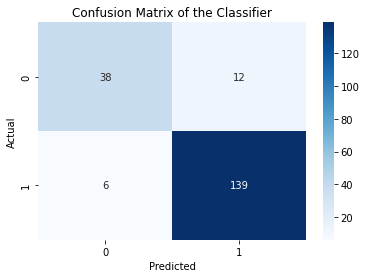

In [25]:
#print the final confusion matrix
visual_cm(true_y = y_test, pred_y = GBM_pred)

<p>As seen below, since the tuned model predicts better on the test set it does significantly better on all scores. However, compared to how it does on the train data the gap in these scores for the tuned model becomes more obvious.</p>
<p>To lower our chances of making a type two error, we should look at the recall score (which increases as the number of false negatives decreases). Both models have a good score in this field, and perhaps it can be argued that in general the tuned model does better in this particular score, but I maintain my stance on the importance of the stability of the model. </p>

In [26]:
GBM_pred_train = GBM_fit.predict(x_train)
GBM_tuned_pred_train = GBM_tuned_fit.predict(x_train)
#scores from the confusion matrix
scores_table(y_test, GBM_pred)
scores_table(y_test, GBM_tuned_pred)

╒═════════════╤═════════╕
│             │   Score │
╞═════════════╪═════════╡
│ Accuracy    │  0.9077 │
├─────────────┼─────────┤
│ Precision   │  0.9205 │
├─────────────┼─────────┤
│ Recall      │  0.9586 │
├─────────────┼─────────┤
│ Specificity │  0.76   │
╘═════════════╧═════════╛
╒═════════════╤═════════╕
│             │   Score │
╞═════════════╪═════════╡
│ Accuracy    │  0.9385 │
├─────────────┼─────────┤
│ Precision   │  0.9404 │
├─────────────┼─────────┤
│ Recall      │  0.9793 │
├─────────────┼─────────┤
│ Specificity │  0.82   │
╘═════════════╧═════════╛


In [27]:


#scores from the confusion matrix for trained data
scores_table(y_train, GBM_pred_train)
scores_table(y_train, GBM_tuned_pred_train)

╒═════════════╤═════════╕
│             │   Score │
╞═════════════╪═════════╡
│ Accuracy    │  0.9178 │
├─────────────┼─────────┤
│ Precision   │  0.9132 │
├─────────────┼─────────┤
│ Recall      │  0.9832 │
├─────────────┼─────────┤
│ Specificity │  0.7258 │
╘═════════════╧═════════╛
╒═════════════╤═════════╕
│             │   Score │
╞═════════════╪═════════╡
│ Accuracy    │  0.8892 │
├─────────────┼─────────┤
│ Precision   │  0.8888 │
├─────────────┼─────────┤
│ Recall      │  0.9732 │
├─────────────┼─────────┤
│ Specificity │  0.6427 │
╘═════════════╧═════════╛


In [28]:
#storing the strings and other variables to be printed
table = [ ["RF",RF_train_score,RF_test_score, RF_auc_score, cm(y_test, RF_pred)], ["RF tuned",RF_tuned_train_score,RF_tuned_test_score, RF_tuned_auc_score, cm(y_test, RF_tuned_pred) ],  ["GBM (Final Model)",GBM_train_score,GBM_test_score,GBM_auc_score, cm(y_test, GBM_pred)],["GBM tuned",GBM_tuned_train_score,GBM_tuned_test_score, GBM_tuned_auc_score, cm(y_test, GBM_tuned_pred)]]

# printing the results in a table
print(tabulate(table, headers=["Classifier", "Train score", "Test score", "AUC score", "Confusion matrix"], tablefmt="fancy_grid"))


╒═══════════════════╤═══════════════╤══════════════╤═════════════╤════════════════════╕
│ Classifier        │   Train score │   Test score │   AUC score │ Confusion matrix   │
╞═══════════════════╪═══════════════╪══════════════╪═════════════╪════════════════════╡
│ RF                │        0.7756 │       0.8359 │      0.8503 │ (44, 6, 26, 119)   │
├───────────────────┼───────────────┼──────────────┼─────────────┼────────────────────┤
│ RF tuned          │        0.7921 │       0.8513 │      0.8607 │ (44, 6, 23, 122)   │
├───────────────────┼───────────────┼──────────────┼─────────────┼────────────────────┤
│ GBM (Final Model) │        0.9178 │       0.9077 │      0.8593 │ (38, 12, 6, 139)   │
├───────────────────┼───────────────┼──────────────┼─────────────┼────────────────────┤
│ GBM tuned         │        0.8892 │       0.9385 │      0.8997 │ (41, 9, 3, 142)    │
╘═══════════════════╧═══════════════╧══════════════╧═════════════╧════════════════════╛
